In [76]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

# Linear solver
def linear_solve(a, L, uh, bc): 
    A = assemble(a)
    b = assemble(L) 
    
    bc.apply(A, b) 
    x = uh.vector() 
    
    solve(A, x, b)
    
    return x

# Get modes
def extract_modes(A, neigs):
    solver = SLEPcEigenSolver(A)
    solver.parameters["solver"] = "krylov-schur"
    solver.parameters["problem_type"] = "gen_hermitian"
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 0.
    solver.solve(neigs)
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('Modes/modes.pvd')  
    
    for md in range(neigs):
        r, c, rx, cx = solver.get_eigenpair(md)
        # Initialize function and assign eigenvector
        if not (r > 1.-1.e-8 and r < 1.+1.e-8):    # filter out spurious eigenvectors
            mode = Function(V)
            mode.rename("mode",'mode')
            mode.vector()[:] = rx
            modes.append(mode)
            eigvalues.append(r)
            # Save mode to file
            vtkfile << (mode, r)    
            del(mode)
    
    return modes, eigvalues

# RHS
def L_func(f_exp, v):
    return f_exp * v * dx

# LHS
def a_func(u, v):
    return inner(grad(u), grad(v))*dx

# Modal solver
def modal_solve(a, L, uh, bc, neigs): 
    A = PETScMatrix()
    b = PETScVector()
    
    assemble_system(a, L, bc, A_tensor=A, b_tensor=b)
    
    modes, evs = extract_modes(A, neigs)
    
    nmodes = len(evs)
    l_vec = len(modes[0].vector().array())
    mode_array = np.zeros((l_vec, nmodes))
    
    for i in range(nmodes):
        mode_array[:, i] = modes[i].vector().array()
    
    F = np.dot(mode_array.T, b.array())
    K = np.dot(np.dot(mode_array.T, A.array()), mode_array)
    c_0 = np.linalg.solve(K, F)
    
    return c_0, modes, evs

# Plot the errors against h
def plot_errors(h, error_norm, nmodes):
    
    fig, ax = plt.subplots()

    colors = ['r', 'b']

    ax.loglog(h, error_norm, colors[0] + '^-', label='$L_2$')

    coeffs = np.polyfit(np.log2(h), np.log2(error_norm), deg=1)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp2(poly(np.log2(x)))
    plt.loglog(h, yfit(h), colors[1] + '.--', label="$y=Ch^{" + str(round(coeffs[0], 3)) + "}$")

    legend = ax.legend(shadow=True, fontsize=10)
    ax.set_xlabel("$h_\mathrm{max}$", fontsize=10)
    ax.set_ylabel("Errors", fontsize=10)

    ax.set_title('Convergence Plot for '+str(nmodes)+' modes', fontsize=15)
    str_ = 'convplot_P1_'+str(nmodes)+'modes.png'
    plt.savefig(str_)
    
    return

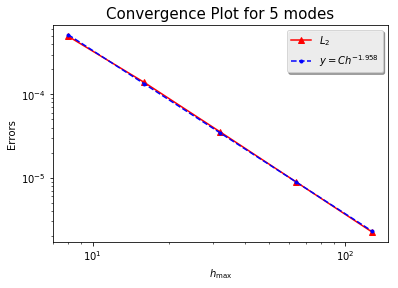

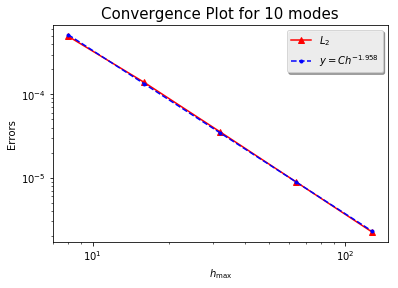

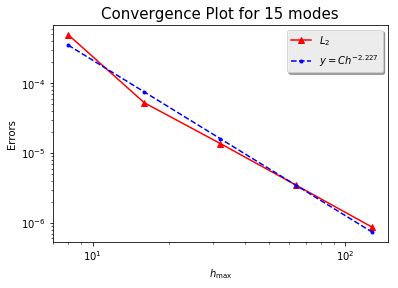

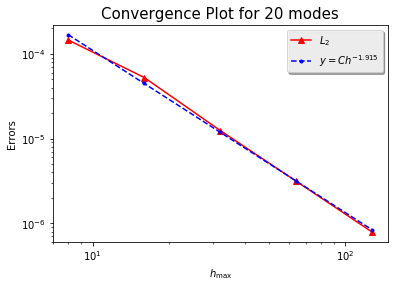

In [82]:
# Convergence test with Lagrange P1 elements and first 5,10,15,20 modes
for i in range(1,5):
    neigs = 5*i
    error_norm = []
    h = []
    
    for k in range(3,8):    
        h.append(2**k)
        mesh = UnitSquareMesh(h[k-3], h[k-3])   # generate mesh
        V = FunctionSpace(mesh, 'P', 1)    # create finite element function space V, based on linear Lagrange elements
        # plot(mesh)

        f_exp = Expression('2*pi*pi * sin(pi*x[0]) * sin(pi*x[1])', degree=4)

        # Define boundary conditions
        u_D = Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=4)
        bc = DirichletBC(V, u_D, boundary)

        # Define variational problem
        u = TrialFunction(V)
        v = TestFunction(V)
        a = a_func(u, v) # inner(grad(u), grad(v))*dx
        L = L_func(f_exp, v) # f_exp * v * dx

        ###### REFERENCE SOLUTION ######
        uref = Function(V)
        uref.vector()[:] = linear_solve(a, L, uref, bc)

        ###### MODAL SOLUTION ######
        uh = Function(V)
        c_0, modes, evs = modal_solve(a, L, uh, bc, neigs)
        uh = c_0[0]*modes[0]

        n = len(evs)
        modes_total = [0.0]
        for i in range(n):
            modes_total += c_0[i]*modes[i].vector().array()

        # Compute errors
        uref_array = uref.vector().array()
        # e_h =  uref_array - modes_total
        error_norm.append(np.linalg.norm(uref_array - modes_total) / np.linalg.norm(uref_array))

    # print uh
    # print error_norm
    plot_errors(h, error_norm, neigs)


Modal sum of displacement with 20 modes compared to reference solution
Calling FFC just-in-time (JIT) compiler, this may take some time.


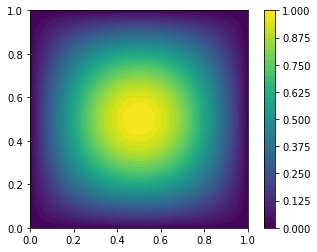

Difference between direct and modal solution
Calling FFC just-in-time (JIT) compiler, this may take some time.


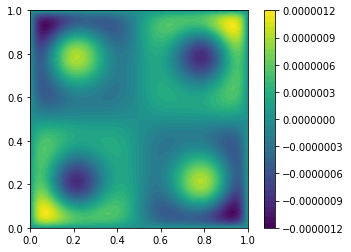

Modal sum of displacement with 20 modes compared to reference solution


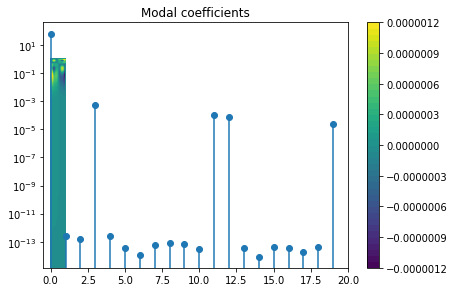

Calling FFC just-in-time (JIT) compiler, this may take some time.


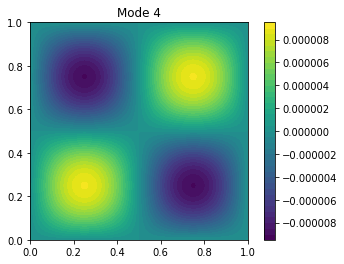

norm of mode 4 relative to norm of reference solution
-9.04106490389e-06


In [78]:
###### POST-PROCESSING ######
fig = plt.figure()
ttl="Modal sum of displacement with " + str(len(evs)) + " modes compared to reference solution"
modes_total = sum(c_0[:]*modes[:])
print(ttl)
ax1 = plot(modes_total)
cbar = plt.colorbar(ax1)
# plt.title('Modal sum of displacement with %s modes'%str(len(evs)))
plt.show()

print("Difference between direct and modal solution")
ax = plot(uref - modes_total)
cbar = plt.colorbar(ax)
plt.show()

fig = plt.figure()
print("Modal sum of displacement with " + str(len(evs)) + " modes compared to reference solution")
#plt.title(ttl)
modes_total = sum(c_0[:]*modes[:])
ax = plot(uref - modes_total)
cbar = plt.colorbar(ax)
plt.tight_layout()

plt.stem(abs(c_0))
plt.title("Modal coefficients")
plt.yscale('log')
plt.xlim([-0.5, neigs])
plt.show()

idx = 3
fig = plt.figure()
plt.title("Mode {}".format(idx+1))
ax = plot(c_0[idx]*modes[idx])
cbar = plt.colorbar(ax)
plt.show()

print("norm of mode {} relative to norm of reference solution".format(idx+1))
print(c_0[idx]*modes[idx].vector().norm("l2") / abs(uref.vector()[:].norm("l2")))